In [2]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from urllib.request import urlretrieve
from os.path import isfile, isdir, getsize
from os import mkdir, makedirs, remove, listdir
from tqdm import tqdm

import zipfile
import tarfile
import glob
import shutil

import pickle

import datetime
import time
import h5py



/home/akarsh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [4]:
from keras import backend as K
from keras.callbacks import  EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from kerasba.models import Sequential, model_from_json
from keras.layers import  Conv2D, MaxPool2D,Activation,Dropout,Flatten,Dense,BatchNormalization



Using TensorFlow backend.


Lets look at some library functions one by one:
* **ImageDataGenerator :** Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
    * **rotation_range :** Int. Degree range for random rotations.
    * **width_shift_range :**  Float, 1-D array-like or int float: fraction of total width, if < 1, or pixels if >= 1. 1-D array-like: random elements from the array. int: integer number of pixels from interval  (-width_shift_range, +width_shift_range)
    * **height_shift_range :** 
    * **rescale :** rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
    * **shear_range :**  Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    * **zoom_range :** Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]. 
    * **horizontal_flip :** Boolean. Randomly flip inputs horizontally.
    * **fill_mode :** 'nearest': aaaaaaaa|abcd|dddddddd


In [5]:
# defining constant values
img_width = 100
img_height = 100
split_size = 0.2
batch_size = 128

channnel = 1

In [6]:

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('bottleneck_features_train.npy'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Bottleneck features') as pbar:
        urlretrieve(
                'https://www.dropbox.com/s/a38gpvdcryw0kfc/bottleneck.zip?dl=1',
                'bottleneck.zip',
                pbar.hook)

    with zipfile.ZipFile('bottleneck.zip') as f:
        f.extractall('./')
        
    files = listdir('bottleneck 2/')
    
    for f in files:
        shutil.move('bottleneck 2/'+f,'./')
    shutil.rmtree('bottleneck 2/')
    remove('bottleneck.zip')
    


In [7]:
catdog_dataset_folder_path = 'catdog/train/'


In [8]:
files = glob.glob(catdog_dataset_folder_path + '**/*.jpg')


size = np.zeros(len(files))


In [9]:
labels = np.array([1]*12500+[0]*12500)

In [10]:
len_data = len(files)
train_examples = 20000
test_examples = len_data - train_examples

#randomly choosing 20000 as training and testing cases

permutation = np.random.permutation(len_data)
train_set = [files[i] for i in permutation[:train_examples]]
test_set = [files[i] for i in permutation[-test_examples:]]
train_labels = labels[permutation[:train_examples]]
test_labels = labels[permutation[-test_examples:]]

train_folder = catdog_dataset_folder_path + '/training_set'
test_folder = catdog_dataset_folder_path + '/validation_folder'

if isdir(train_folder): #if directory already exists
    shutil.rmtree(train_folder)    
if isdir(test_folder): #if directory already exists
    shutil.rmtree(test_folder) 
    
makedirs(train_folder+'/cat/')
makedirs(train_folder+'/dog/')
makedirs(test_folder+'/cat/')
makedirs(test_folder+'/dog/')

for f,i in zip(train_set, train_labels):
    if i==0:
        shutil.copy2(f, train_folder+'/cat/')
    else:
        shutil.copy2(f, train_folder+'/dog/')
        
for f,i in zip(test_set, test_labels):
    if i==0:
        shutil.copy2(f, test_folder+'/cat/')
    else:
        shutil.copy2(f, test_folder+'/dog/')


Found 20000 images belonging to 2 classes.


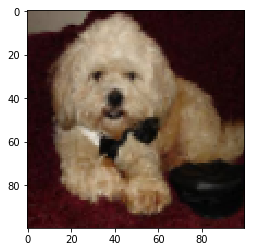

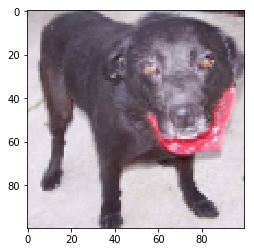

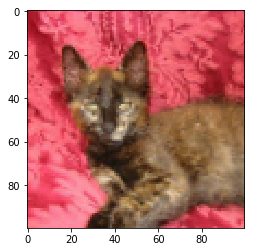

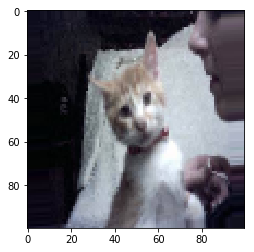

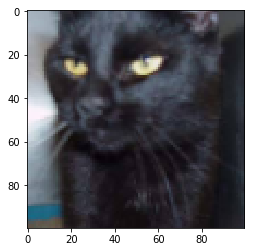

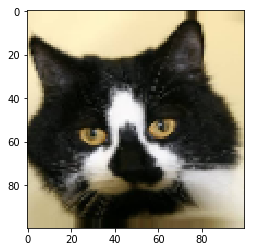

In [11]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=0.2,
        horizontal_flip=True)

img_height = img_width = 100
channels = 3
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode=None)

i = 0
img_list = []
for batch in train_generator: #.flow(x, batch_size=1)
    img_list.append(batch)
    i += 1
    if i > 5:
        break
        

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()

## Model 

In [53]:
model = Sequential()

model.add(Conv2D(8,(3,3),input_shape=(img_width,img_height,channels),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(16,padding='same',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,padding='same',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


#Compile Model
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
activation_5 (Activation)    (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 33, 16)        1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 33, 33, 16)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
__________

In [54]:
batch_size = 128
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')
model.fit_generator(train_generator, train_examples//batch_size, epochs=5)

Found 20000 images belonging to 2 classes.
Epoch 1/5
156/156 [==============================] - 687s 4s/step - loss: 0.6440 - acc: 0.6435
Epoch 2/5
156/156 [==============================] - 225s 1s/step - loss: 0.5575 - acc: 0.7168
Epoch 3/5
156/156 [==============================] - 106s 680ms/step - loss: 0.5256 - acc: 0.7379
Epoch 4/5
156/156 [==============================] - 102s 656ms/step - loss: 0.4947 - acc: 0.7610
Epoch 5/5
156/156 [==============================] - 103s 663ms/step - loss: 0.4755 - acc: 0.7715


In [55]:
### Continue here
batch_size = 1
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=False)
y_pred = model.predict_generator(test_generator, test_examples//batch_size, workers=4)
# model.predict_classes(test_x)
# np.count_nonzero(y_pred == test_y)/len(test_y)

Found 5000 images belonging to 2 classes.


In [57]:
correct = 0
for i, f in enumerate(test_generator.filenames):
    if f.startswith('cat') and y_pred[i]<0.5:
        correct +=1
    if f.startswith('dog') and y_pred[i]>=0.5:
        correct +=1

print('Correct predictions: '+str(correct/len(test_generator.filenames)))

Correct predictions: 0.7428


In [58]:
batch_size = 6
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True)
x_test, y_test = next(test_generator)

p = model.predict(x_test)
p = np.hstack([y_pred, 1-y_pred])
label_dict = {0: 'cat', 1: 'dog'}

Found 5000 images belonging to 2 classes.


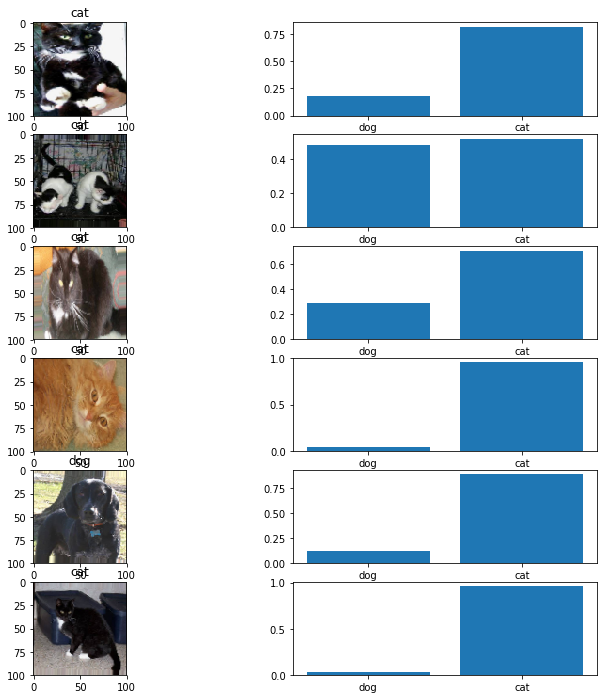

In [60]:
plt.figure(figsize=(12,12))

for i in range(batch_size):
    plt.subplot(batch_size,2,2*i+1)
    plt.imshow(x_test[i])
    plt.title(label_dict[y_test[i]])
    
    plt.subplot(batch_size,2,2*i+2)
    plt.bar(range(2),p[i])
    plt.xticks(range(2), ['dog', 'cat'])
#     plt.show()

plt.show()

## Transfer Learning- Part 1

In [17]:
from keras import applications

datagen = ImageDataGenerator(rescale=1.0/255)
model = applications.VGG16(include_top=False,input_shape=(img_width,img_height,channels))


In [18]:
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

In [20]:
bottleneck_features_train.shape


(19872, 3, 3, 512)

In [21]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 20000 images belonging to 2 classes.


In [22]:
batch_size = 128
valid_generator = datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [23]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,180,161
Trainable params: 1,180,161
Non-trainable params: 0
_________________________________________________________________


In [24]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

labels = np.array([0 if f.startswith('cat') else 1 for f in generator.filenames])[:len(bottleneck_features_train)]
model.fit(bottleneck_features_train, labels, epochs=15, batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Epoch 1/15
19872/19872 [==============================] - 6s 313us/step - loss: 0.5374 - acc: 0.7773
Epoch 2/15
19872/19872 [==============================] - 4s 208us/step - loss: 0.3523 - acc: 0.8455
Epoch 3/15
19872/19872 [==============================] - 4s 208us/step - loss: 0.3212 - acc: 0.8588
Epoch 4/15
19872/19872 [==============================] - 4s 199us/step - loss: 0.3034 - acc: 0.8660
Epoch 5/15
19872/19872 [==============================] - 4s 195us/step - loss: 0.2860 - acc: 0.8762
Epoch 6/15
19872/19872 [==============================] - 4s 202us/step - loss: 0.2747 - acc: 0.8812
Epoch 7/15
19872/19872 [==============================] - 4s 204us/step - loss: 0.2665 - acc: 0.8883
Epoch 8/15
19872/19872 [==============================] - 4s 205us/step - loss: 0.2584 - acc: 0.8907
Epoch 9/15
19872/19872 [==============================] - 4s 204us/step - loss: 0.2495 - acc: 0.8955
Epoch 10/15
19872/19872 [=======================

In [25]:
with open('bottleneck_features_valid.npy','rb') as f:
    bottleneck_features_valid = pickle.load(f)
valid_labels = np.array([0 if f.startswith('cat') else 1 for f in valid_generator.filenames])[:len(bottleneck_features_valid)]
y_valid_pred = model.predict_classes(bottleneck_features_valid)
accuracy = np.count_nonzero(valid_labels == y_valid_pred.ravel())/len(valid_labels)

print('\nThe accuracy is: '+str(accuracy))


The accuracy is: 0.915605749486653


## Transfer Learning - Part 2
We refine the model by adjusting the last convolutional layer 
Note that vgg16 is one type of Model and not sequential . hence we cannot add  the top layer .



In [26]:
from keras.models import Model

In [27]:
vgg16 = applications.VGG16(include_top=False,weights='imagenet',input_shape=(img_width,img_height,channels))

combinedModel = Model(inputs= vgg16.input, outputs = model(vgg16.outputs))

for layer in combinedModel.layers[:-3]:
    layer.trainable = False

In [28]:
combinedModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [29]:
model.save_weights('fc_model.h5')


In [30]:
combinedModel.compile(loss='binary_crossentropy',optimizer = optimizers.RMSprop(lr=1e-4,decay=0.9),metrics=['accuracy'])

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
combinedModel.fit_generator(
    train_generator,
    steps_per_epoch=train_examples//batch_size,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=test_examples//batch_size)

Epoch 1/2
